# Assignment A4-RNN by ShiKai@20xxxxxx

**December 2, 2024**

---

## 任务描述

**任务（30分）：构建一个用于起名字的循环神经网络**

- 数据：8000多个英文名字
- 采用已有的英文名字，训练一个RNN，实现一个起名字的计算机程序，当输入名字的第一个或前几个字母时，程序自动生成后续的字母，直到生成一个名字的结束符。
- 采用可视化技术，绘制出模型为每个时刻预测的前5个最可能的候选字母。 



**附加题（10分）：**

- 事实上，你也可以给定结尾的若干个字母，或者随意给出中间的若干个字母，让RNN补全其它字母，从而得到一个完整的名字。请尝试设计并实现一个这样的RNN模型。

- 从模型生成的名字中，挑选你最喜欢的一个，并采用可视化技术，绘制生成这个名字的过程。 

背景知识：给定大量的文本数据，可训练一个基于循环神经网络的语言模型，该模型可用于计算一个句子的出现概率（P(w1, w2, ..., wT)），或者根据上文中的词推断某个词作为下一个词的出现概率（P(wt｜w1, w2, ..., wt-1)）。 

---

✅ 基本任务

本任务通过循环神经网络（RNN）构建了一个名字（First Name）生成器，利用现有的英文名字数据集来训练模型。当输入名字的第一个字母或前几个字母时，模型能够自动生成后续的字母，直到生成一个完整的名字。此外，还实现了可视化功能，绘制了模型在每个时间步预测的前五个最可能的候选字母。

✅ 附加任务

在此基础上进一步扩展了生成器的功能，使得模型不仅能够根据开始字母生成名字，还可以接受部分名字作为输入，从而自动补全缺失的字符。此外，添加了可视化技术，绘制了生成名字过程中前五个最可能的字符的概率分布，帮助更直观地理解模型的预测过程。

---

## 数据集介绍

本实验使用的姓名数据集来自 [name-dataset](https://github.com/philipperemy/name-dataset) (../data/name_dataset)。挑选了 `US` 地区的 `First Name` 数据，并对数据进行了一些筛选，去除了其中的拉丁语、希腊语、希伯来语等非英文名字。最终选用的数据集包含了约 8000 个英文名字。

---

## 实验设置

### 1. 数据预处理

数据预处理主要包括以下几个步骤：
- 从 `name-dataset` 的 `US.csv` 文件中读取英文名字
- 对每个名字进行了简单的清洗，确保其字符全部为英文字母
- 创建了字符到索引（`char_to_index`）以及索引到字符（`index_to_char`）的映射，用于在训练过程中将字符转换为数字索引，模型输出的预测结果再通过索引映射回字符

### 2. 模型架构

本实验中，使用了一个简单的 RNN模型，主要包括以下三个部分：
1. **嵌入层（Embedding Layer）**：将字符转换为固定维度的向量表示，帮助模型更好地理解字符之间的关系。
2. **RNN 层**：循环神经网络用于学习名字中的字符序列，通过时间步（即每个字符）进行处理。
3. **输出层**：根据 RNN 的输出，计算下一个字符的概率分布，并选取概率最高的字符作为生成的下一个字母。

### 3. 训练过程

- 使用 Adam 优化器（`optim.Adam`）来优化模型参数。
- 损失函数采用交叉熵损失（`nn.CrossEntropyLoss`），用于计算预测字符和真实字符之间的差异。
- 每次训练时，我们从名字中随机选择一个名字，将该名字的前 `n-1` 个字母作为输入，后 `n-1` 个字母作为目标进行训练。

训练过程中，设置了训练迭代次数（`n_iters`）和每多少次打印一次训练损失（`print_every`）。

### 4. 生成名字

在训练完成后使用模型生成名字，模型通过输入第一个字母（或者部分字母，也扩展了这个过程，使得模型能够接受部分名字作为输入并补全剩余部分）来生成后续字符，直到生成一个完整的名字或者遇到结束符。

---

## 实验结果

具体效果见本 PDF 末尾。

### 1. 训练过程

在训练过程中，模型逐渐收敛，损失函数值逐渐降低，说明模型成功学习了如何根据已有字母生成新的字母。训练过程中，每100次迭代打印损失值，用于观察训练进度。

### 2. 生成的名字

使用模型生成多个名字，输入部分字母后，模型成功生成了合理的名字。例如，输入部分名字 `"trum"`，模型生成了完整的名字 `"trumiscondrand"`，可以根据需要调整生成的最大长度。生成的名字有时会长于设置的 `max_length`，这是由于模型没有严格限制长度。因此我们对生成函数进行了改进，确保名字生成过程不超过设定的最大长度。

### 3. 可视化结果

通过绘制生成过程中的每个时刻模型预测的前五个最可能的字符的概率分布，能够看到模型在每个时间步如何逐步优化预测，并逐渐生成完整的名字。

In [155]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random, string, csv
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [156]:
#################### Data Preprocessing ####################

name_path = "../data/name_dataset/data/US.csv"

dump_path = "../data/name_dataset/data/US_dump.csv"

names = []

def chk_alph(name:str) -> bool:
    if len(name) == 0:
        return False
    for c in name:
        _ord = ord(c)
        if _ord > 122:
            return False
        if _ord < 65:
            return False
        if _ord > 90 and _ord < 97:
            return False
    return True    


def load_names() -> list:
    # load First names from the dataset
    _fst_names = []
    with open(name_path) as f:
        reader = csv.reader(f)
        for row in reader:
            name = row[0]
            
            # check if the name is in English
            if not chk_alph(name):
                continue
            
            _fst_names.append(name.lower())
    return _fst_names

def save_names(names) -> None:
    print(f"Saving {len(names)} names to: {dump_path}")
    with open(dump_path, 'w') as f:
        writer = csv.writer(f)
        for name in names:
            writer.writerow([name])
            
# 创建字符到索引和索引到字符的映射
all_characters = string.ascii_lowercase + " "  # 可以包括空格
n_characters = len(all_characters)

char_to_index = {ch: i for i, ch in enumerate(all_characters)}
index_to_char = {i: ch for i, ch in enumerate(all_characters)}

# 将名字转换为索引表示
def name_to_tensor(name):
    tensor = torch.zeros(len(name), 1, dtype=torch.long)
    for li, letter in enumerate(name):
        tensor[li] = char_to_index[letter]
    return tensor

names = load_names()
save_names(names)

Saving 30976530 names to: ../data/name_dataset/data/US_dump.csv


In [157]:
class RNNModel(nn.Module):
    def __init__(self, n_chars, hidden_size=128):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        
        # 嵌入层：字符到嵌入空间的映射
        self.embedding = nn.Embedding(n_chars, hidden_size)
        
        # RNN层
        self.rnn = nn.RNN(hidden_size, hidden_size)
        
        # 输出层：从RNN的输出到字符的映射
        self.out = nn.Linear(hidden_size, n_chars)
    
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output, hidden = self.rnn(embedded, hidden)
        output = self.out(output[0])
        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=next(self.parameters()).device)

In [158]:
# 训练
def train(model, names, n_iters=1000, print_every=100):
    optimizer = optim.Adam(model.parameters(), lr=0.005)
    criterion = nn.CrossEntropyLoss()
    
    for iter in range(1, n_iters + 1):
        name = random.choice(names)
        input_tensor = name_to_tensor(name[:-1]).to(device)  # 除去最后一个字符，作为输入
        target_tensor = name_to_tensor(name[1:]).to(device)  # 从第二个字符开始，作为目标

        hidden = model.init_hidden()

        model.zero_grad()

        loss = torch.tensor(0, dtype=torch.float, requires_grad=True)
        for i in range(input_tensor.size(0)):
            input_char = input_tensor[i]
            target_char = target_tensor[i]
            
            output, hidden = model(input_char, hidden)
            step_loss = criterion(output, target_char.view(-1))  # 单步损失
            loss = loss + step_loss
        
        loss.backward()
        optimizer.step()
        
        if iter % print_every == 0:
            print(f'Iteration {iter}/{n_iters} Loss: {loss.item() / len(name):.4f}')

In [159]:
model = RNNModel(n_characters).to(device)

In [160]:
train(model, names, n_iters=10000, print_every=10)

Iteration 10/10000 Loss: 2.1193
Iteration 20/10000 Loss: 3.4320
Iteration 30/10000 Loss: 2.8734
Iteration 40/10000 Loss: 2.2870
Iteration 50/10000 Loss: 3.2480
Iteration 60/10000 Loss: 2.7778
Iteration 70/10000 Loss: 2.0080
Iteration 80/10000 Loss: 1.7850
Iteration 90/10000 Loss: 2.1272
Iteration 100/10000 Loss: 2.5575
Iteration 110/10000 Loss: 1.8231
Iteration 120/10000 Loss: 0.8215
Iteration 130/10000 Loss: 2.2220
Iteration 140/10000 Loss: 2.4635
Iteration 150/10000 Loss: 1.9412
Iteration 160/10000 Loss: 3.4045
Iteration 170/10000 Loss: 1.9282
Iteration 180/10000 Loss: 1.8443
Iteration 190/10000 Loss: 2.0796
Iteration 200/10000 Loss: 2.6041
Iteration 210/10000 Loss: 1.4681
Iteration 220/10000 Loss: 2.6639
Iteration 230/10000 Loss: 2.5117
Iteration 240/10000 Loss: 1.9225
Iteration 250/10000 Loss: 2.7214
Iteration 260/10000 Loss: 1.9820
Iteration 270/10000 Loss: 1.9147
Iteration 280/10000 Loss: 1.8392
Iteration 290/10000 Loss: 1.9502
Iteration 300/10000 Loss: 1.7882
Iteration 310/10000

## 给出开始位置的字母

In [161]:
def generate_name(model, start_letters='a', max_length=20):
    device = next(model.parameters()).device
    hidden = model.init_hidden().to(device)

    # 将多个字母的字符串转换为输入张量
    input_tensor = torch.tensor([char_to_index[ch] for ch in start_letters], dtype=torch.long).view(-1, 1).to(device)

    name = start_letters

    for i in range(max_length):
        output, hidden = model(input_tensor[-1], hidden)  # 只使用最后一个字符作为输入
        topv, topi = output.topk(1)
        next_char_index = topi[0][0].item()
        next_char = index_to_char[next_char_index]

        name += next_char
        input_tensor = torch.cat((input_tensor, torch.tensor([[next_char_index]], dtype=torch.long).to(device)), dim=0)

        if next_char == ' ':
            break
    
    return name.strip()


In [162]:
def visualize(model, start_letters='a', max_length=20):
    device = next(model.parameters()).device
    hidden = model.init_hidden().to(device)

    # 将多个字母的字符串转换为输入张量
    input_tensor = torch.tensor([char_to_index[ch] for ch in start_letters], dtype=torch.long).view(-1, 1).to(device)

    name = start_letters
    all_probs = []

    for i in range(max_length):
        output, hidden = model(input_tensor[-1], hidden)  # 只使用最后一个字符作为输入
        topv, topi = output.topk(5)
        top_chars = [index_to_char[topi[0][j].item()] for j in range(5)]
        top_probs = torch.nn.functional.softmax(topv, dim=1).squeeze().tolist()

        all_probs.append(top_probs)

        name += top_chars[0]  # 选择概率最大的字符
        input_tensor = torch.cat((input_tensor, torch.tensor([[topi[0][0].item()]], dtype=torch.long).to(device)), dim=0)

        if top_chars[0] == ' ':
            break
    
    # 可视化每个时刻的前5个字符的概率分布
    fig, ax = plt.subplots(figsize=(10, 5))
    all_probs = np.array(all_probs)
    for i in range(5):
        ax.plot(all_probs[:, i], label=f"Top {i+1}: {top_chars[i]}")
    ax.set_title("Top 5 Character Prediction Probabilities")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Probability")
    ax.legend()
    plt.show()

    return name.strip()


In [163]:
generated_name = generate_name(model, start_letters ='albre', max_length=8)
print(f"Generated Name: {generated_name}")

Generated Name: albrettianalp


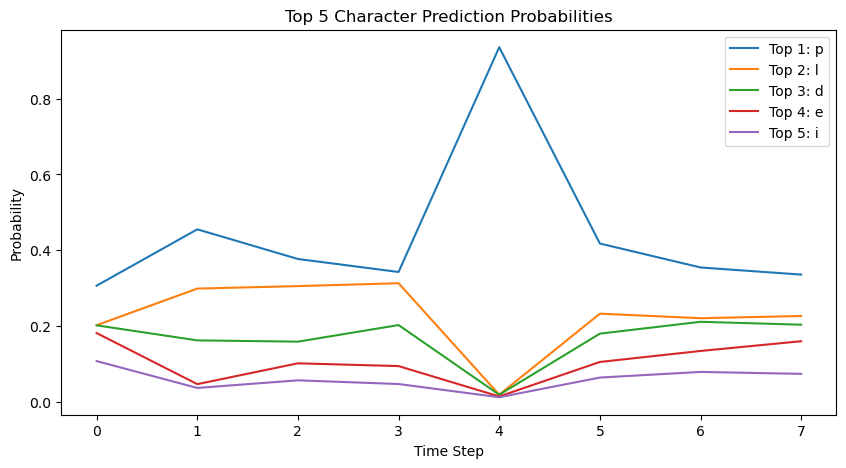

'albrettianalp'

In [164]:
visualize(model, start_letters='albre', max_length=8)

## 给出任意位置的字母

In [165]:
def generate_name(model, partial_name='', max_length=10):
    device = next(model.parameters()).device
    hidden = model.init_hidden().to(device)
    
    # 将部分名字转换为张量（包括开始字母、结尾字母或中间字母）
    input_tensor = torch.tensor([char_to_index[ch] for ch in partial_name], dtype=torch.long).view(-1, 1).to(device)
    
    # 生成的名字
    name = partial_name

    # 从已知部分开始生成
    name_len = max_length - len(partial_name)
    for i in range(name_len):
        output, hidden = model(input_tensor[-1], hidden)  # 只使用最后一个字符作为输入
        topv, topi = output.topk(1)
        next_char_index = topi[0][0].item()
        next_char = index_to_char[next_char_index]

        name += next_char
        input_tensor = torch.cat((input_tensor, torch.tensor([[next_char_index]], dtype=torch.long).to(device)), dim=0)

        if next_char == ' ':
            break
    
    return name.strip()

In [166]:
def visualize(model, partial_name='', max_length=10):
    device = next(model.parameters()).device
    hidden = model.init_hidden().to(device)
    
    # 将部分名字转换为张量（包括开始字母、结尾字母或中间字母）
    input_tensor = torch.tensor([char_to_index[ch] for ch in partial_name], dtype=torch.long).view(-1, 1).to(device)
    
    name = partial_name
    all_probs = []

    # 从已知部分开始生成
    name_len = max_length - len(partial_name)
    for i in range(name_len):
        output, hidden = model(input_tensor[-1], hidden)  # 只使用最后一个字符作为输入
        topv, topi = output.topk(5)
        top_chars = [index_to_char[topi[0][j].item()] for j in range(5)]
        top_probs = torch.nn.functional.softmax(topv, dim=1).squeeze().tolist()

        all_probs.append(top_probs)

        name += top_chars[0]  # 选择概率最大的字符
        input_tensor = torch.cat((input_tensor, torch.tensor([[topi[0][0].item()]], dtype=torch.long).to(device)), dim=0)

        if top_chars[0] == ' ':
            break
    
    # 可视化每个时刻的前5个字符的概率分布
    fig, ax = plt.subplots(figsize=(10, 5))
    all_probs = np.array(all_probs)
    for i in range(5):
        ax.plot(all_probs[:, i], label=f"Top {i+1}: {top_chars[i]}")
    ax.set_title("Top 5 Character Prediction Probabilities")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Probability")
    ax.legend()
    plt.show()

    return name.strip()

In [167]:
generated_name = generate_name(model, partial_name='mich', max_length=7)
print(f"Generated Name: {generated_name}")

Generated Name: michnan


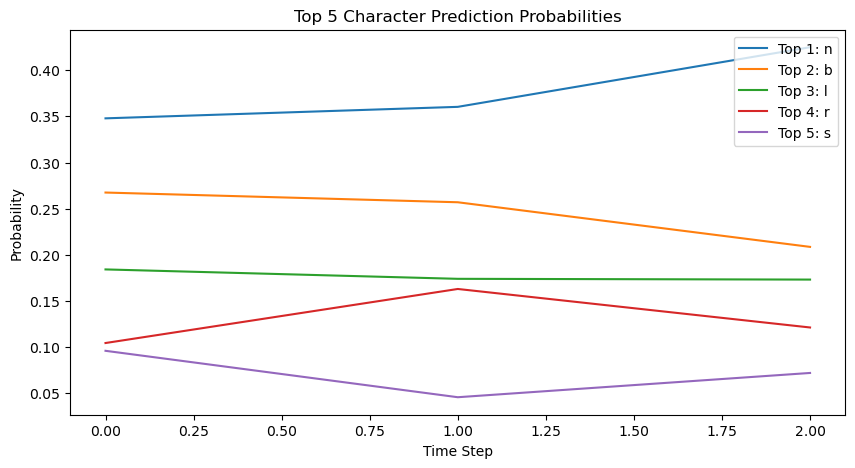

'michnan'

In [168]:
visualize(model, partial_name='mich', max_length=7)